# Travelling Salesman Problem using Genetic Algorithm

### Importing Libraries

In [2]:
%pip install pandas seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from itertools import permutations, combinations
from random import shuffle
import random
import numpy as np
import statistics
import pandas as pd
import seaborn as sns

## Data

### Cities Coordinates and Algorithm Parameters

In [4]:
x = [0,3,6,7,15,10,16,5,8,1.5]
y = [1,2,1,4.5,-1,2.5,11,6,9,12]
cities_names = ["Gliwice", "Cairo", "Rome", "Krakow", "Paris", "Alexandria", "Berlin", "Tokyo", "Rio", "Budapest"]
city_coords = dict(zip(cities_names, zip(x, y)))
n_population = 250
crossover_per = 0.8
mutation_per = 0.2
n_generations = 200

## Visualising Cities

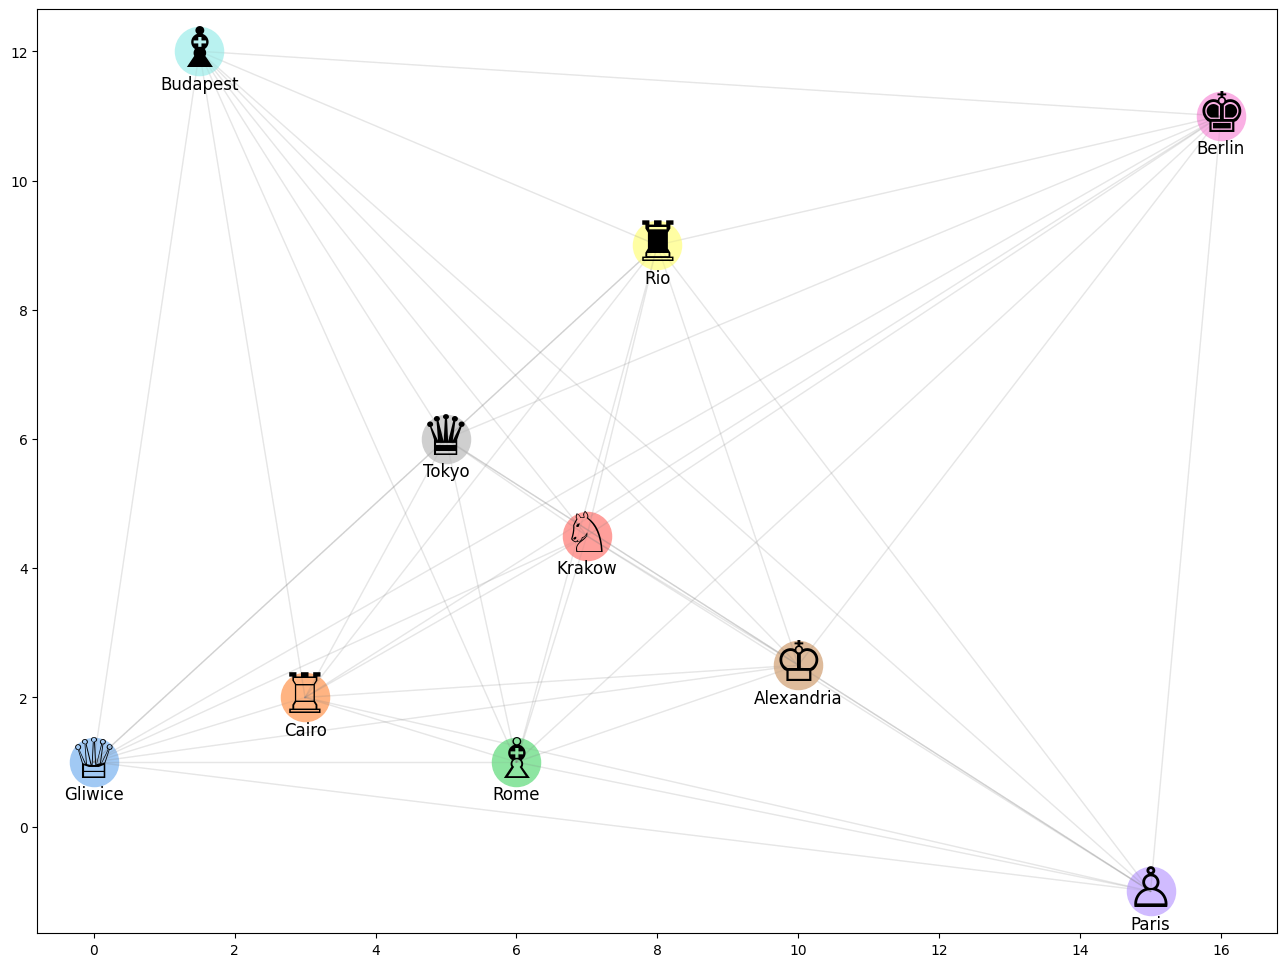

In [5]:
# Pastel Pallete
colors = sns.color_palette("pastel", len(cities_names))

# City Icons
city_icons = {
    "Gliwice": "♕",
    "Cairo": "♖",
    "Rome": "♗",
    "Krakow": "♘",
    "Paris": "♙",
    "Alexandria": "♔",
    "Berlin": "♚",
    "Tokyo": "♛",
    "Rio": "♜",
    "Budapest": "♝"
}

fig, ax = plt.subplots()

ax.grid(False)  # Grid

for i, (city, (city_x, city_y)) in enumerate(city_coords.items()):
    color = colors[i]
    icon = city_icons[city]
    ax.scatter(city_x, city_y, c=[color], s=1200, zorder=2)
    ax.annotate(icon, (city_x, city_y), fontsize=40, ha='center', va='center', zorder=3)
    ax.annotate(city, (city_x, city_y), fontsize=12, ha='center', va='bottom', xytext=(0, -30),
                textcoords='offset points')

    # Connect cities with opaque lines
    for j, (other_city, (other_x, other_y)) in enumerate(city_coords.items()):
        if i != j:
            ax.plot([city_x, other_x], [city_y, other_y], color='gray', linestyle='-', linewidth=1, alpha=0.1)

fig.set_size_inches(16, 12)
plt.show()

## Population Function (Random Initialization)

In [ ]:
def initial_population(cities_list, n_population = 250):
    
    """
    Generating initial population of cities randomly selected from the all possible permutations 
    of the given cities. 
    Input:
    1- Cities list 
    2- Number of population 
    Output:
    Generated lists of cities
    """
    
    population_perms = []
    for _ in range(n_population):
        shuffle(cities_list)
        population_perms.append(cities_list.copy())
    # Remove duplicates by converting to a set and back to a list
    population_perms = list(set(tuple(p) for p in population_perms))
    # Convert back to list of lists
    population_perms = [list(p) for p in population_perms]
    # If the number of unique permutations is less than n_population, fill the rest with random permutations
    while len(population_perms) < n_population:
        shuffle(cities_list)
        population_perms.append(cities_list.copy())
    # Ensure the population size is exactly n_population
    population_perms = population_perms[:n_population]
    # Convert back to list of lists
    population_perms = [list(p) for p in population_perms]
    # Convert to a DataFrame for better visualization
    population_df = pd.DataFrame(population_perms, columns=cities_list)
    # Display the DataFrame
    print(population_df.head())
        
    return population_perms

In [22]:
initial_population(cities_names, n_population)

       Rome     Tokyo    Berlin   Paris Budapest      Rio       Cairo  \
0     Cairo  Budapest      Rome  Krakow    Paris  Gliwice      Berlin   
1    Krakow     Tokyo  Budapest    Rome  Gliwice    Cairo      Berlin   
2      Rome  Budapest   Gliwice     Rio    Cairo   Berlin  Alexandria   
3  Budapest      Rome    Berlin     Rio    Tokyo    Paris      Krakow   
4     Paris  Budapest    Krakow   Cairo     Rome   Berlin       Tokyo   

    Krakow     Gliwice  Alexandria  
0    Tokyo         Rio  Alexandria  
1    Paris  Alexandria         Rio  
2   Krakow       Tokyo       Paris  
3  Gliwice       Cairo  Alexandria  
4  Gliwice         Rio  Alexandria  


[['Cairo',
  'Budapest',
  'Rome',
  'Krakow',
  'Paris',
  'Gliwice',
  'Berlin',
  'Tokyo',
  'Rio',
  'Alexandria'],
 ['Krakow',
  'Tokyo',
  'Budapest',
  'Rome',
  'Gliwice',
  'Cairo',
  'Berlin',
  'Paris',
  'Alexandria',
  'Rio'],
 ['Rome',
  'Budapest',
  'Gliwice',
  'Rio',
  'Cairo',
  'Berlin',
  'Alexandria',
  'Krakow',
  'Tokyo',
  'Paris'],
 ['Budapest',
  'Rome',
  'Berlin',
  'Rio',
  'Tokyo',
  'Paris',
  'Krakow',
  'Gliwice',
  'Cairo',
  'Alexandria'],
 ['Paris',
  'Budapest',
  'Krakow',
  'Cairo',
  'Rome',
  'Berlin',
  'Tokyo',
  'Gliwice',
  'Rio',
  'Alexandria'],
 ['Alexandria',
  'Paris',
  'Budapest',
  'Cairo',
  'Tokyo',
  'Rio',
  'Rome',
  'Gliwice',
  'Berlin',
  'Krakow'],
 ['Paris',
  'Tokyo',
  'Gliwice',
  'Rio',
  'Rome',
  'Cairo',
  'Berlin',
  'Alexandria',
  'Krakow',
  'Budapest'],
 ['Alexandria',
  'Tokyo',
  'Rio',
  'Krakow',
  'Gliwice',
  'Budapest',
  'Cairo',
  'Rome',
  'Paris',
  'Berlin'],
 ['Tokyo',
  'Rome',
  'Cairo',
  'Rio',

## Distance between two cities

In [7]:
def dist_two_cities(city_1, city_2):
    
    """
    Calculating the distance between two cities  
    Input:
    1- City one name 
    2- City two name
    Output:
    Calculated Euclidean distance between two cities
    """
    
    city_1_coords = city_coords[city_1]
    city_2_coords = city_coords[city_2]
    return np.sqrt(np.sum((np.array(city_1_coords) - np.array(city_2_coords))**2))
    

## Total distance traveled by individual 

In [8]:
def total_dist_individual(individual):
    
    """
    Calculating the total distance traveled by individual, 
    one individual means one possible solution (1 permutation)
    Input:
    1- Individual list of cities 
    Output:
    Total distance traveled 
    """
    
    total_dist = 0
    for i in range(0, len(individual)):
        if(i == len(individual) - 1):
            total_dist += dist_two_cities(individual[i], individual[0])
        else:
            total_dist += dist_two_cities(individual[i], individual[i+1])
    return total_dist

## Fitness probability function

In [18]:
def fitness_prob(population):
    """
    Calculating the fitness probability 
    Input:
    1- Population  
    Output:
    Population fitness probability 
    """
        
    fitness = []
    for individual in population:
        fitness.append(1 / total_dist_individual(individual))
    fitness_sum = sum(fitness)
    fitness_prob = [f / fitness_sum for f in fitness]
    return fitness_prob

In [19]:
fitness_prob(initial_population(cities_names, n_population))

         Rome  Budapest   Paris    Rio Alexandria    Berlin      Krakow  \
0        Rome    Berlin   Cairo  Tokyo      Paris       Rio     Gliwice   
1  Alexandria  Budapest     Rio  Tokyo      Paris    Berlin     Gliwice   
2      Berlin     Paris     Rio  Tokyo      Cairo      Rome  Alexandria   
3    Budapest    Berlin  Krakow  Tokyo        Rio   Gliwice        Rome   
4        Rome    Berlin   Cairo  Paris      Tokyo  Budapest      Krakow   

      Gliwice    Cairo       Tokyo  
0    Budapest   Krakow  Alexandria  
1        Rome   Krakow       Cairo  
2    Budapest  Gliwice      Krakow  
3  Alexandria    Cairo       Paris  
4  Alexandria  Gliwice         Rio  


[np.float64(0.0036413885649522553),
 np.float64(0.004043661330359865),
 np.float64(0.004309374851400032),
 np.float64(0.0038920321365378528),
 np.float64(0.003444675187137412),
 np.float64(0.00392036008549124),
 np.float64(0.0042095339870630525),
 np.float64(0.003657936081379573),
 np.float64(0.003766288574557119),
 np.float64(0.004136497352620661),
 np.float64(0.00423451777660711),
 np.float64(0.00423951976683668),
 np.float64(0.004063475211225683),
 np.float64(0.0038821149019908656),
 np.float64(0.0037495528123266805),
 np.float64(0.0035128335131832922),
 np.float64(0.0038828562914886983),
 np.float64(0.004319953364988981),
 np.float64(0.0040225839888330195),
 np.float64(0.003958633337272538),
 np.float64(0.003722594780721911),
 np.float64(0.003755267388741317),
 np.float64(0.0038611838688358685),
 np.float64(0.0037127912078322362),
 np.float64(0.003679428803062352),
 np.float64(0.00395268816039131),
 np.float64(0.003932693370138577),
 np.float64(0.004594578428794002),
 np.float64(0.

## Roulette wheel

In [20]:
def roulette_wheel(population, fitness_probs):
    """
    Implement selection strategy based on roulette wheel proportionate selection. 
    Input:
    1- population
    2- fitness probabilities 
    Output:
    selected individual
    """
    cumulative_probs = np.cumsum(fitness_probs)
    random_value = random.random()
    for i, individual in enumerate(population):
        if random_value < cumulative_probs[i]:
            return individual
    return population[-1]  # Fallback in case of rounding errors

## Crossover

In [ ]:
def crossover(parent_1, parent_2):
    """
    Implement mating strategy using simple crossover between 2 parents
    Input:
    1- parent 1
    2- parent 2 
    Output:
    1- offspring 1
    2- offspring 2
    """
    # Write your code here
    

## Mutation

In [ ]:
def mutation(offspring):
    """
    Implement mutation strategy in a single offspring
    Input:
    1- offspring individual
    Output:
    1- mutated offspring individual
    """
    # Write your code here
    

## Algorithm

In [ ]:
def run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per):
    
    population = initial_population(cities_names, n_population)
    fitness_probs = fitness_prob(population)
    
    parents_list = []
    for i in range(0, int(crossover_per * n_population)):
        parents_list.append(roulette_wheel(population, fitness_probs))

    offspring_list = []    
    for i in range(0,len(parents_list), 2):
        offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])

    #     print(offspring_1)
    #     print(offspring_2)
    #     print()

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_1 = mutation(offspring_1)
    #         print("Offspring 1 mutated", offspring_1)

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_2 = mutation(offspring_2)
    #         print("Offspring 2 mutated", offspring_2)


        offspring_list.append(offspring_1)
        offspring_list.append(offspring_2)

    mixed_offspring = parents_list + offspring_list

    fitness_probs = fitness_prob(mixed_offspring)
    sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
    best_fitness_indices = sorted_fitness_indices[0:n_population]
    best_mixed_offsrping = []
    for i in best_fitness_indices:
        best_mixed_offsrping.append(mixed_offspring[i])
        


    for i in range(0, n_generations):
        # if (i%10 == 0):
            # print("Generation: ", i)
        
        fitness_probs = fitness_prob(best_mixed_offsrping)
        parents_list = []
        for i in range(0, int(crossover_per * n_population)):
            parents_list.append(roulette_wheel(best_mixed_offsrping, fitness_probs))

        offspring_list = []    
        for i in range(0,len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_1 = mutation(offspring_1)

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_2 = mutation(offspring_2)

            offspring_list.append(offspring_1)
            offspring_list.append(offspring_2)


        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_prob(mixed_offspring)
        sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
        best_fitness_indices = sorted_fitness_indices[0:int(0.8*n_population)]

        best_mixed_offsrping = []
        for i in best_fitness_indices:
            best_mixed_offsrping.append(mixed_offspring[i])
            
        old_population_indices = [random.randint(0, (n_population - 1)) for j in range(int(0.2*n_population))]
        for i in old_population_indices:
#             print(i)
            best_mixed_offsrping.append(population[i])
            
        random.shuffle(best_mixed_offsrping)
            
    return best_mixed_offsrping

In [ ]:
best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)

In [ ]:
total_dist_all_individuals = []
for i in range(0, n_population):
    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))

In [ ]:
index_minimum = np.argmin(total_dist_all_individuals)

### Optimum Solution

In [ ]:
minimum_distance = min(total_dist_all_individuals)

In [ ]:
minimum_distance

np.float64(61.13744551656402)

#### Optimum Solution is the distance of 61.137

In [ ]:
# shortest_path = offspring_list[index_minimum]
shortest_path = best_mixed_offsrping[index_minimum]

In [ ]:
shortest_path

['Budapest',
 'Tokyo',
 'Gliwice',
 'Cairo',
 'Rome',
 'Krakow',
 'Alexandria',
 'Paris',
 'Berlin',
 'Rio']

### Optimum Solution Visualization

In [ ]:
x_shortest = []
y_shortest = []
for city in shortest_path:
    x_value, y_value = city_coords[city]
    x_shortest.append(x_value)
    y_shortest.append(y_value)
    
x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

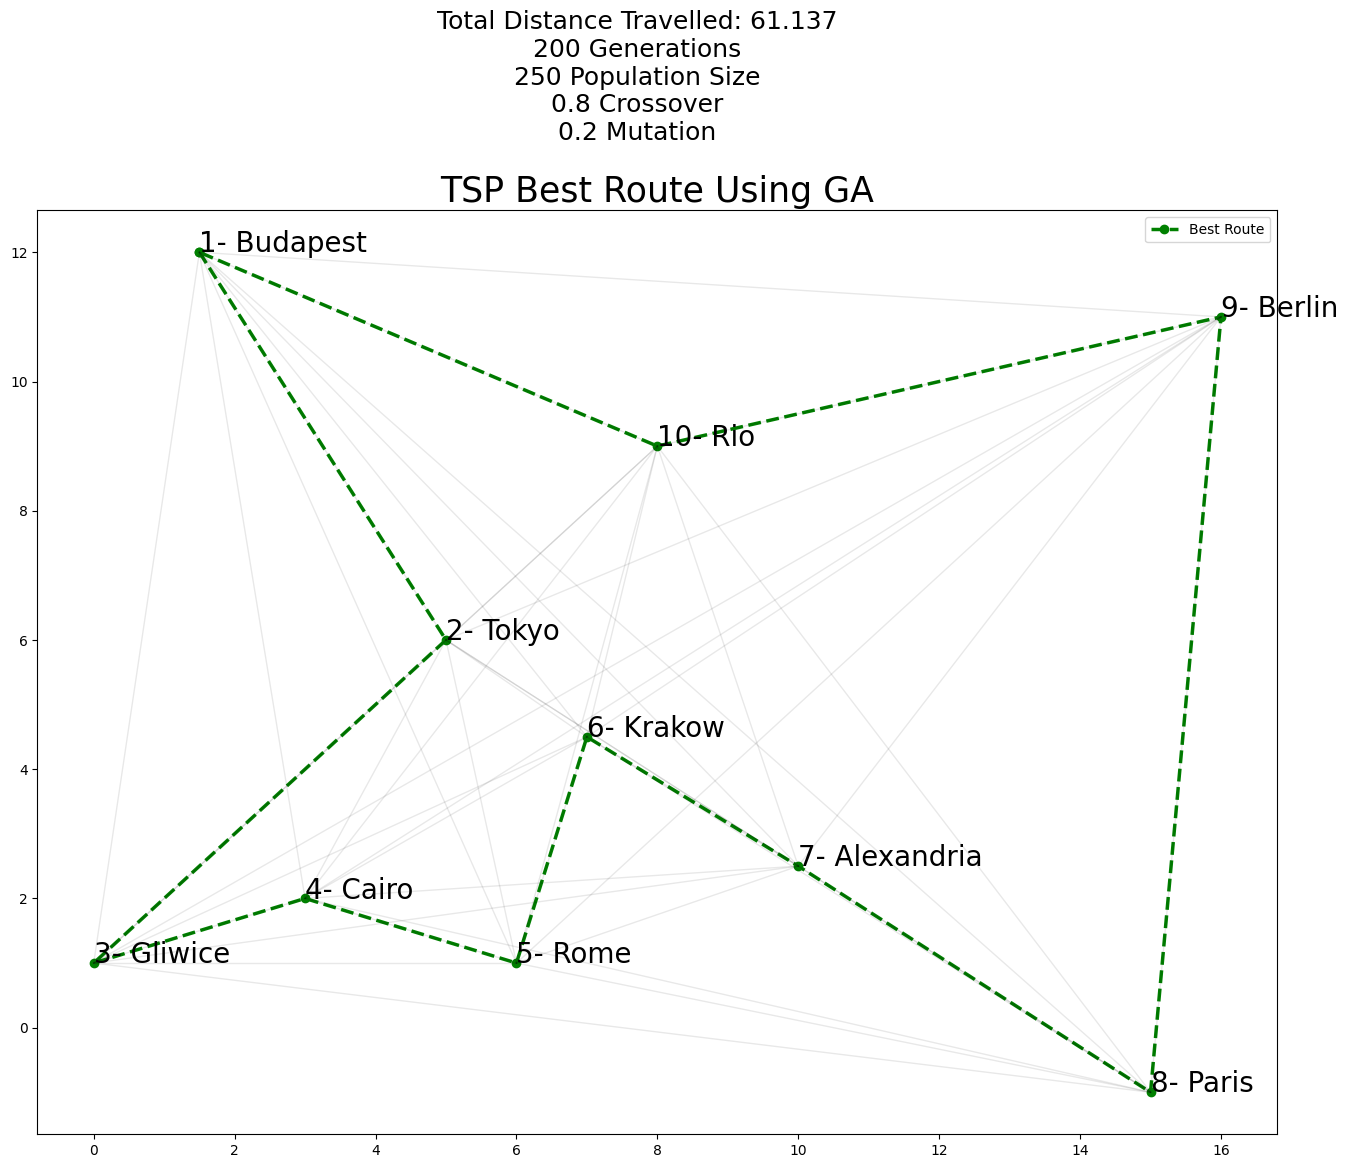

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

for i in range(len(x)):
    for j in range(i + 1, len(x)):
        ax.plot([x[i], x[j]], [y[i], y[j]], 'k-', alpha=0.09, linewidth=1)
        
plt.title(label="TSP Best Route Using GA",
          fontsize=25,
          color="k")

str_params = '\n'+str(n_generations)+' Generations\n'+str(n_population)+' Population Size\n'+str(crossover_per)+' Crossover\n'+str(mutation_per)+' Mutation'
plt.suptitle("Total Distance Travelled: "+ 
             str(round(minimum_distance, 3)) + 
             str_params, fontsize=18, y = 1.047)

for i, txt in enumerate(shortest_path):
    ax.annotate(str(i+1)+ "- " + txt, (x_shortest[i], y_shortest[i]), fontsize= 20)

fig.set_size_inches(16, 12)    
# plt.grid(color='k', linestyle='dotted')
plt.savefig('solution.png')
plt.show()

## Parameters Influence

Try with different ranges, but take into account it takes a lot of time

In [ ]:
n_population_range = [100, 300, 500]
crossover_per_range = [0.5, 0.7, 0.9]
mutation_per_range = [0.1, 0.3, 0.5]
n_trials = 3


n_population_chosen = []
crossover_per_chosen = []
mutation_per_chosen = []
minimium_total_distance_10_iter = []
mean_minimium_total_distance = []

In [ ]:
for n_population in n_population_range:
    for crossover_per in crossover_per_range:
        for mutation_per in mutation_per_range:
            for i in range(0, n_trials):
                best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)
                total_dist_all_individuals = []
                for i in range(0, n_population):
                    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))
                index_minimum = np.argmin(total_dist_all_individuals)
                minimium_total_distance_10_iter.append(min(total_dist_all_individuals))
            mean_minimium_total_distance.append(statistics.mean(minimium_total_distance_10_iter))
            n_population_chosen.append(n_population)
            crossover_per_chosen.append(crossover_per)
            mutation_per_chosen.append(mutation_per)

In [ ]:
parameters_analysis_df = pd.DataFrame(list(zip(n_population_chosen,
                                               crossover_per_chosen,
                                               mutation_per_chosen,
                                               mean_minimium_total_distance)),
               columns =['n population', 
                         'crossover %',
                         'mutation %',
                         'avg min total distance'])

## Parameters Analysis

In [ ]:
parameters_analysis_df

,n population,crossover %,mutation %,avg min total distance
0,100,0.5,0.1,68.179999
1,300,0.5,0.1,67.422352


## Conclusion and Final Notes:

Write here your conclussions